<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [1]:
import os
import sys
import json

import statistics
import collections
import operator
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from matplotlib import colors
import matplotlib.patches as mpatches

from collections import Counter
from collections import OrderedDict

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from  matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler



plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

<h2> Librosa features </h2> 

For each 106,572 tracks, we have 518 Librosa features, having the following cardinalities:

1. **chroma_cens** = 12
2. **chroma_cqt** = 12
3. **chroma_stft** = 12
4. **mfcc** = 20
5. **rmse** = 1
6. **spectral_bandwidth** = 1
7. **spectral_centroid** = 1
8. **spectral_contrast** = 7
9. **spectral_rolloff** = 1
10. **tonnetz** = 6
11. **zcr** = 1

and for each cardinality feature we have the following information:
1. **min** = min feature's value;
2. **max** = max feature's value;
3. **median** = median feature's value;
4. **mean** = avg feature's values;
5. **std** = std feature's values;
6. **skew** = feature's values asymmetry distribution
7. **kurtosis** = feature's values tailedness distribution

In [2]:
librosaFeatures = pd.read_csv('../../data/fma_metadata/features.csv', index_col=0, header=[0, 1, 2])
librosaFeatures.shape

(106574, 518)

In [4]:
librosaFeatures.head(2).T

track_id                              2         3
feature     statistics number                    
chroma_cens kurtosis   01      7.180653  1.888963
                       02      5.230309  0.760539
                       03      0.249321  0.345297
                       04      1.347620  2.295201
                       05      1.482478  1.654031
...                                 ...       ...
zcr         mean       01      0.085629  0.084578
            median     01      0.071289  0.063965
            min        01      0.000000  0.000000
            skew       01      2.089872  1.716724
            std        01      0.061448  0.069330

[518 rows x 2 columns]

In [5]:
librosa_columns = {}
librosa_columns_info = set()
for c in librosaFeatures.columns:
    librosa_columns_info.add(c[1])
    try:
        if librosa_columns[str(c[0])] < c[2]:
            librosa_columns[str(c[0])] = c[2]
    except KeyError:
        librosa_columns[str(c[0])] = c[2]
print("Librosa columns:", librosa_columns)
print("Librosa columns info:", librosa_columns_info)

Librosa columns: {'chroma_cens': '12', 'chroma_cqt': '12', 'chroma_stft': '12', 'mfcc': '20', 'rmse': '01', 'spectral_bandwidth': '01', 'spectral_centroid': '01', 'spectral_contrast': '07', 'spectral_rolloff': '01', 'tonnetz': '06', 'zcr': '01'}
Librosa columns info: {'mean', 'skew', 'min', 'median', 'std', 'max', 'kurtosis'}


<h6>Keeping only 'mean' columns</h6> 

In [33]:
mean_columns = []
mean_features = []
one_nine_numbers = list(range(1, 10))
for key, value in librosa_columns.items():
    for n in range(1, int(value) + 1):
        n = str(n)
        if int(n) in one_nine_numbers:
            n = "0" + n
        column_name = key + "_" + n
        mean_columns.append(column_name)
        tmp_serie = librosaFeatures[key]['mean'][n]
        mean_features.append(tmp_serie)

librosaMeanFeatures = pd.concat(mean_features, axis=1,)
librosaMeanFeatures.shape

(106574, 74)

In [34]:
# rename concatenated DataFrame's columns
librosaMeanFeatures.columns = list(mean_columns)

In [59]:
# librosaMeanFeatures.info()

<h2> Pearson correlation before row filtering</h2>

In [37]:
def normalize_df(df, scaler_flag):
    # for column_name in columns_to_normalize:
    column_names = list(df.columns)
    for column_name in column_names:
        data = df[column_name]
        scaler = None
        if scaler_flag == "min_max":
            scaler = MinMaxScaler()
        elif scaler_flag == "standard":
            scaler = StandardScaler()
        elif scaler_flag == "maxabs":
            scaler = MaxAbsScaler()
        elif scaler_flag == "robust":
            scaler = RobustScaler()
        else:
            print("scaler_flag error")
            sys.exit(-1)
        # fit the model on the feature to normale its values and transform it
        df[column_name] = scaler.fit_transform(df[column_name].values.reshape(-1,1))[:, 0]
    return df

In [99]:
def corrX_orig(df, cut = 0.9) :
    """
    https://towardsdatascience.com/are-you-dropping-too-many-correlated-features-d1c96654abe6
    """
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()

        
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
    # Else: drop(row)
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    # dropcols_idx = drop_set
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

In [130]:
def calcDrop(res):
    # All variables with correlation > cutoff
    all_corr_vars = list(set(res['v1'].tolist() + res['v2'].tolist()))
    
    # All unique variables in drop column
    poss_drop = list(set(res['drop'].tolist()))

    # Keep any variable not in drop column
    keep = list(set(all_corr_vars).difference(set(poss_drop)))
     
    # Drop any variables in same row as a keep variable
    p = res[ res['v1'].isin(keep)  | res['v2'].isin(keep) ][['v1', 'v2']]
    q = list(set(p['v1'].tolist() + p['v2'].tolist()))
    drop = (list(set(q).difference(set(keep))))

    # Remove drop variables from possible drop 
    poss_drop = list(set(poss_drop).difference(set(drop)))
    
    # subset res dataframe to include possible drop pairs
    m = res[ res['v1'].isin(poss_drop)  | res['v2'].isin(poss_drop) ][['v1', 'v2','drop']]
        
    # remove rows that are decided (drop), take set and add to drops
    more_drop = set(list(m[~m['v1'].isin(drop) & ~m['v2'].isin(drop)]['drop']))
    for item in more_drop:
        drop.append(item)
         
    return drop

In [131]:
def corrX_new(df, cut = 0.9) :
       
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    dropcols = list()
    
    res = pd.DataFrame(columns=(['v1', 'v2', 'v1.target', 
                                 'v2.target','corr', 'drop' ]))
    
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    dropcols.append(row)
                    drop = corr_mtx.columns[row]
                else: 
                    dropcols.append(col)
                    drop = corr_mtx.columns[col]
                
                s = pd.Series([ corr_mtx.index[row],
                up.columns[col],
                avg_corr[row],
                avg_corr[col],
                up.iloc[row,col],
                drop],
                index = res.columns)
        
                res = res.append(s, ignore_index = True)
    
    dropcols_names = calcDrop(res)
    
    return(dropcols_names)

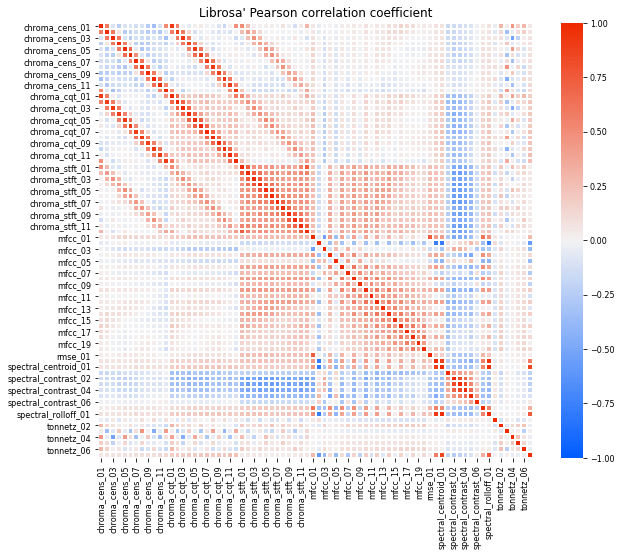

In [71]:
norm_librosaMeanFeatures = normalize_df(librosaMeanFeatures, "min_max")
corr = norm_librosaMeanFeatures.corr()

f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(255, 30, 255, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0.0, vmax = 1, vmin = -1, 
                                                                              square=True, linewidths=1, ax=ax)

plt.xlabel("")
plt.ylabel("")
plt.title("Librosa' Pearson correlation coefficient")
plt.show()

In [87]:
# investigating negative correlation
threshold = -0.6
for i in range(len(corr.columns)):
    for j in range(i):
        if (corr.iloc[i, j] <= threshold):
            print(corr.columns[i], corr.columns[j], round(corr.iloc[i, j], 2), sep="\t")

spectral_bandwidth_01	mfcc_02	-0.76
spectral_centroid_01	mfcc_02	-0.78
spectral_rolloff_01	mfcc_02	-0.77


In [83]:
round(corr['mfcc_02']['zcr_01'], 2)

-0.58

**mfcc_02 is negative correlated with spectral_bandwidth_01 (-0.76), spectral_centroid_01 (-0.78) and spectral_rolloff_01 (-0.77)**, since:

- spectral_bandwidth_01 is positive correlated with spectral_centroid_01 (+0.89) and spectral_rolloff_01 (+0.93);
- spectral_centroid_01 is positive correlated with spectral_bandwidth_01 (+0.89), spectral_rolloff_01 (+0.98) and zcr_01 (+0.85);
- spectral_rolloff_01 is positive correlated with spectral_bandwidth_01 (+0.93), spectral_centroid_01 (+0.98) and zcr_01 (+0.75).

<b><font color="green">
KEEP: mfcc_02
    
REMOVE: spectral_bandwidth_01, spectral_centroid_01, spectral_rolloff_01
</font></b>

In [123]:
# investigating positive correlation
threshold = 0.6
not_mentioned_columns = set(librosaMeanFeatures.columns)
for i in range(len(corr.columns)):
    for j in range(i):
        if (corr.iloc[i, j] >= threshold):
            try:
                not_mentioned_columns.remove(corr.columns[i])
            except KeyError:
                pass
            try:
                not_mentioned_columns.remove(corr.columns[j])
            except KeyError:
                pass
print("not_mentioned_columns", len(not_mentioned_columns))

not_mentioned_columns 20


In [124]:
# investigating positive correlation
already_lookup_columns = []


threshold = 0.6
for i in range(len(corr.columns)):
    for j in range(i):
        if (corr.iloc[i, j] >= threshold):
            if corr.columns[i] and corr.columns[j] in already_lookup_columns:
                continue
            print(corr.columns[i], corr.columns[j], "+" + str(round(corr.iloc[i, j], 2)), sep="\t")

chroma_cens_03	chroma_cens_02	+0.61
chroma_cens_06	chroma_cens_05	+0.67
chroma_cens_08	chroma_cens_07	+0.64
chroma_cens_11	chroma_cens_10	+0.64
chroma_cqt_01	chroma_cens_01	+0.93
chroma_cqt_02	chroma_cens_02	+0.89
chroma_cqt_02	chroma_cqt_01	+0.68
chroma_cqt_03	chroma_cens_03	+0.93
chroma_cqt_03	chroma_cqt_02	+0.71
chroma_cqt_04	chroma_cens_04	+0.9
chroma_cqt_04	chroma_cqt_03	+0.7
chroma_cqt_05	chroma_cens_05	+0.93
chroma_cqt_05	chroma_cens_06	+0.65
chroma_cqt_05	chroma_cqt_04	+0.69
chroma_cqt_06	chroma_cens_05	+0.62
chroma_cqt_06	chroma_cens_06	+0.91
chroma_cqt_06	chroma_cqt_05	+0.73
chroma_cqt_07	chroma_cens_07	+0.9
chroma_cqt_07	chroma_cqt_06	+0.68
chroma_cqt_08	chroma_cens_07	+0.63
chroma_cqt_08	chroma_cens_08	+0.92
chroma_cqt_08	chroma_cqt_07	+0.7
chroma_cqt_09	chroma_cens_09	+0.89
chroma_cqt_09	chroma_cqt_08	+0.69
chroma_cqt_10	chroma_cens_10	+0.92
chroma_cqt_10	chroma_cens_11	+0.62
chroma_cqt_10	chroma_cqt_09	+0.68
chroma_cqt_11	chroma_cens_11	+0.9
chroma_cqt_11	chroma_cqt_10	+0

In [134]:
# old_drop = corrX_orig(norm_librosaMeanFeatures, cut = 0.6)
# remanining_columns = sorted(list(set(librosaMeanFeatures).difference(set(old_drop))))
# print("remanining_columns", len(remanining_columns))
# remanining_columns

In [132]:
new_drop = corrX_new(norm_librosaMeanFeatures, cut = 0.6)
remanining_columns = sorted(list(set(librosaMeanFeatures).difference(set(new_drop))))
print("remanining_columns", len(remanining_columns))
remanining_columns

remanining_columns 43


['chroma_cens_01',
 'chroma_cens_03',
 'chroma_cens_04',
 'chroma_cens_06',
 'chroma_cens_07',
 'chroma_cens_09',
 'chroma_cens_11',
 'chroma_cens_12',
 'chroma_cqt_02',
 'chroma_stft_03',
 'chroma_stft_05',
 'chroma_stft_08',
 'chroma_stft_10',
 'chroma_stft_12',
 'mfcc_02',
 'mfcc_03',
 'mfcc_04',
 'mfcc_05',
 'mfcc_06',
 'mfcc_07',
 'mfcc_09',
 'mfcc_10',
 'mfcc_11',
 'mfcc_13',
 'mfcc_14',
 'mfcc_15',
 'mfcc_16',
 'mfcc_17',
 'mfcc_19',
 'mfcc_20',
 'rmse_01',
 'spectral_contrast_01',
 'spectral_contrast_03',
 'spectral_contrast_05',
 'spectral_contrast_06',
 'spectral_contrast_07',
 'tonnetz_01',
 'tonnetz_02',
 'tonnetz_03',
 'tonnetz_04',
 'tonnetz_05',
 'tonnetz_06',
 'zcr_01']